In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

In [31]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Gothic', 'Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [19]:
import msparser

In [20]:
import re
from datetime import timedelta

In [21]:
info = []
for i in range(10):
    with open(f'in/bcspwr{i+1:02d}.txt') as f:
        text = f.read()
        head = text.split('\n')[0].split(' ')
        info.append({
            'r': int(head[0]),
            'c': int(head[1]),
            'nonzeros': sum(line.count(' ')//2 for line in text.split('\n')[1:])
        })
        

In [92]:
class Algorithm():
    timeparser = re.compile(r'([0-9.:]+)elapsed')
    dateparser = re.compile(r'(?P<minutes>\d+):(?P<seconds>\d+\.\d+)')

    def __init__(self, name):
        self.name = name
        self._entire_time()
        self._detailed_time()
        self._max_memory()

    def _entire_time(self):
        res = []
        with open(f"bench/{self.name}.txt") as f:
            text = f.read()
            for line, _ in list(zip(*[iter(text.split('\n'))]*2)):
                m = Algorithm.timeparser.search(line)
                if m is None:
                    print(line)
                    return
                time_text, = m.groups(1)
                time_parsed = {k: float(v) for k,v in Algorithm.dateparser.match(time_text).groupdict().items()}
                time = np.timedelta64(timedelta(**time_parsed))
                res.append(time)
        self.entire_time = np.array(res).astype(np.float64)
    
    def _detailed_time(self):
        res = []
        with open(f"bench/{self.name}.detail.txt") as f:
            lines = f.read().split('\n')
            for data in list(zip(*[iter(lines)]*(len(lines)//10))):
                times = []
                for line in data:
                    times.append(float(line.split(' ')[1]))
                res.append(times)
        self.detailed_time = res
    
    def _max_memory(self):
        res = []
        for i in range(10):
            data = msparser.parse_file(f'bench/{self.name}.memory/{i+1}.txt')
            peak = data['snapshots'][data['peak_snapshot_index']]
            mem = peak['mem_heap'] + peak['mem_heap_extra'] + peak['mem_stack']
            res.append(mem)
        self.max_memory = np.array(res)





In [93]:
algname = dict([l.split(' ')[::-1] for l in """2.1 b
2.2 c
2.3 f
2.4 a
2.5 d
2.6 g""".split('\n')])

In [94]:
algorithms = {num: Algorithm(name) for num, name in [l.split(' ') for l in """2.1 b
2.2 c
2.3 f
2.4 a
2.5 d
2.6 g""".split('\n')]}

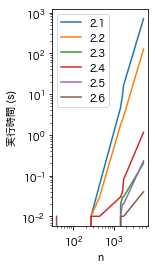

In [48]:
for num, alg in algorithms.items():
    plt.plot([d['r'] for d in info], alg.entire_time.astype(np.float64)/10**6, label=num)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
plt.xlabel('n')
plt.ylabel('実行時間 (s)')
plt.legend()

plt.savefig('report/img/entire.png', bbox_inches='tight', dpi=300)
plt.show()

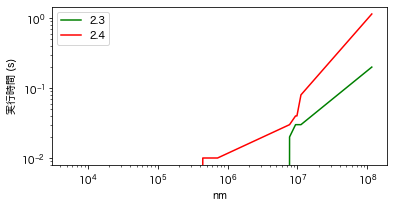

In [97]:
for num, alg in algorithms.items():
    if num not in ['2.3', '2.4']:
        continue
    plt.plot([d['r']*d['nonzeros'] for d in info], alg.entire_time.astype(np.float64)/10**6, label=num, color={'2.3':'green', '2.4':'red'}[num])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
plt.xlabel('nm')
plt.ylabel('実行時間 (s)')
plt.legend()

plt.savefig('report/img/entire-nm.png', bbox_inches='tight', dpi=300)
plt.show()

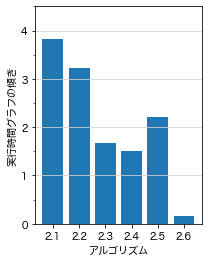

In [81]:


plt.figure(figsize=(3, 4))

plt.bar(list(algorithms), [np.polyfit(np.log([d['r'] for d in info])[alg.entire_time > 0], np.log(alg.entire_time[alg.entire_time > 0]), 1)[0] for num, alg in algorithms.items()])

ax = plt.gca()
major_ticks = np.arange(0, 5, 1)
minor_ticks = np.arange(0, 5, 0.5)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

plt.xlabel('アルゴリズム')
plt.ylabel('実行時間グラフの傾き') 

plt.grid(which='major', color='lightgray', axis='y', linestyle='-')


plt.savefig('report/img/slope.png', bbox_inches='tight', dpi=300)
plt.show()

In [66]:
np.array([d['r'] for d in info])[alg.entire_time.nonzero()], alg.entire_time[alg.entire_time.nonzero()].astype(np.float64)

(array([ 274,  443, 1454, 1612, 1624, 1723, 5300]),
 array([1.000e+04, 6.000e+04, 4.720e+06, 9.300e+06, 1.000e+07, 1.647e+07,
        7.072e+08]))

In [62]:
alg.entire_time

array([10000,     0,     0,     0,     0, 10000, 10000, 10000, 10000,
       40000], dtype='timedelta64[us]')

In [52]:
processes = {i: v for i,v in enumerate('メモリ確保・入力読み込み 行列積計算 出力 メモリ解放'.split(' '))}
procdic = {
    'a': [0, 1, 2 ,3 ,3],
    'b': [0, 1, 2],
    'c': [0,1,2],
    'd': [0,0,1,2,3,3],
    'f': [0,1,2],
    'g': [0,0,1,2,3,3]
}

In [53]:
times = {}
for name in procdic:
    alg = algorithms[algname[name]]
    data = alg.detailed_time[-1]
    if len(data) != len(procdic[name]):
        print(name, data, procdic[name])
        raise Error('yabaizo')
    time = [0,0,0,0]
    for i, t in zip(procdic[name], data):
        time[i] += t
    times[algname[name]] = np.array(time)/sum(time)

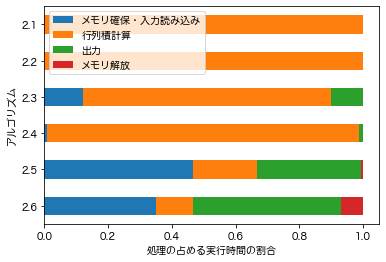

In [105]:
df = pd.DataFrame(times).T.rename(columns=processes).sort_index(ascending=False)
fig = df.plot.barh(stacked=True)
fig.set_ylabel('アルゴリズム')
fig.set_xlabel('処理の占める実行時間の割合')
fig.get_figure().savefig('report/img/ratio.png', bbox_inches='tight', dpi=300)
fig.get_figure().show()

In [99]:
times

{'2.4': array([0.00994499, 0.97626546, 0.01247227, 0.00131727]),
 '2.1': array([4.82062585e-05, 9.99890470e-01, 6.13235983e-05, 0.00000000e+00]),
 '2.2': array([2.36883346e-04, 9.99426392e-01, 3.36724635e-04, 0.00000000e+00]),
 '2.5': array([0.46576751, 0.20213471, 0.32551643, 0.00658135]),
 '2.3': array([0.12104219, 0.77884281, 0.100115  , 0.        ]),
 '2.6': array([0.3500605 , 0.11612665, 0.46386798, 0.06994488])}

In [98]:
plt.bar(list(algorithms), [np.polyfit(np.log([d['r'] for d in info])[alg.entire_time > 0], np.log(alg.entire_time[alg.entire_time > 0]), 1)[0] for num, alg in algorithms.items()])

array([      0.,       0.,       0.,   10000.,   10000.,   30000.,
         40000.,   40000.,   80000., 1150000.])

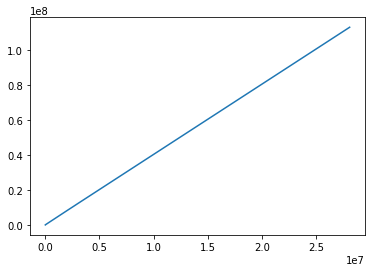

In [186]:
plt.plot([d['r']**2 for d in info], Algorithm('e').max_memory())

NameError: name 'a' is not defined

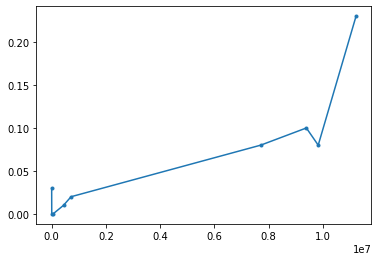

In [204]:
a = Algorithm("a")
plt.plot([d['nonzeros'] * d['r'] for d in info[:-1]], a.entire_time().astype(np.float64)[:-1]/10**6, marker = '.')

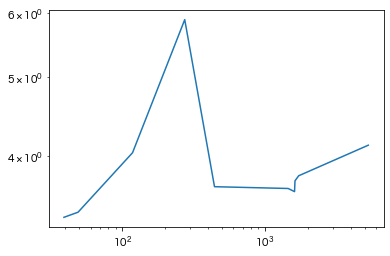

In [86]:
plt.plot([d["r"] for d in info], [d["nonzeros"]/d["r"] for d in info])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

In [84]:
[d["r"] for d in info]

[39, 49, 118, 274, 443, 1454, 1612, 1624, 1723, 5300]

In [85]:
[d["nonzeros"] for d in info]

[131, 167, 476, 1612, 1623, 5300, 5824, 6050, 6511, 21842]

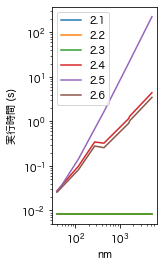

In [95]:
for num, alg in algorithms.items():
    # if num not in ['2.3', '2.4']:
    #     continue
    plt.plot([d['r'] for d in info], alg.max_memory.astype(np.float64)/10**6, label=num)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
plt.xlabel('nm')
plt.ylabel('実行時間 (s)')
plt.legend()

#plt.savefig('report/img/memory.png', bbox_inches='tight', dpi=300)
plt.show()

In [98]:
[d['r']*d['nonzeros'] for d in info]

[5109,
 8183,
 56168,
 441688,
 718989,
 7706200,
 9388288,
 9825200,
 11218453,
 115762600]